In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch.optim as optim

In [4]:
image_path = '/Users/karthik/GANS/1by4-TOPO-Resized/bio_materials/processed_Pattern_FeatureIdx_1000_TopoUnit_4X4.png'

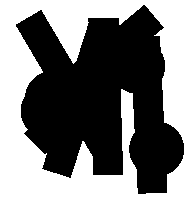

In [5]:
with Image.open(image_path) as img:
    display(img)

In [6]:
path = '/Users/karthik/GANS/1by4-TOPO-Resized/'

img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+ '/' +img)
        
print('Images: ',len(img_names))

Images:  2177


In [7]:
img_sizes = []

rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
            
    except:
        rejected.append(item) 

In [8]:
print(len(img_sizes))

2176


In [9]:
df = pd.DataFrame(img_sizes)

In [10]:
df.head()

,0,1
0,188,179
1,184,188
2,192,192
3,192,192
4,198,195


In [11]:
df.describe()

,0,1
count,2176.000000,2176.000000
mean,190.460018,190.635110
std,5.313203,5.348639
min,166.000000,160.000000
25%,188.000000,189.000000
50%,192.000000,192.000000
75%,193.000000,193.000000
max,200.000000,200.000000


**Parameters**

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

channels = 1  
height = 192
width = 192
material_dim = channels * height * width  # 1 * 224 * 224

lr = 3e-4
z_dim = 112
batch_size = 32
num_epochs = 200

**Transformation**

In [13]:
transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((192,192)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

**Loading the Data**

In [14]:
torch.manual_seed(42)

root = '/Users/karthik/GANS/1by4-TOPO-Resized/'
print(os.path.exists(root))

True


In [15]:
import shutil

class_dir = os.path.join(root, 'bio_materials')
os.makedirs(class_dir, exist_ok=True)

for entry in os.scandir(root):
    if entry.is_file() and entry.name.endswith('.png'):  
        shutil.move(entry.path, class_dir)


train_data = datasets.ImageFolder(root, transform=transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [16]:
for images, labels in train_loader:
    break

In [17]:
images.shape

torch.Size([32, 1, 192, 192])

**Discriminator Network**

In [18]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

**Generator Network**

In [19]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

**Setting Dimensions for Generator & Discriminator**

In [20]:
gen = Generator(g_input_dim = z_dim, g_output_dim = material_dim).to(device)
disc = Discriminator(d_input_dim = material_dim).to(device)

**Optimizer**

In [21]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

**Setting the Tensorboard**

In [22]:
from torch.utils.tensorboard import SummaryWriter 

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0
fixed_noise = torch.randn(16, z_dim).to(device) 

In [23]:
for epoch in range(num_epochs): 
    for batch_idx, (real, _) in enumerate(train_loader):
        
        real = real.view(-1, material_dim).to(device)  # Flatten the images into vectors
        batch_size = real.shape[0]

        # Generate random noise as input for the generator
        noise = torch.randn(batch_size, z_dim).to(device)
        
        # Generate fake images with the generator
        fake = gen(noise)
        
        # Compute the discriminator losses on real images
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        # Compute the discriminator losses on fake images
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        # Combine losses for the discriminator
        lossD = (lossD_real + lossD_fake) / 2
        
        # Update discriminator
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # Update generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()



    # After all batches are processed for the current epoch, check if it's time to print
    if (epoch + 1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1,1,192,192)
            data = real.reshape(-1, 1, 192, 192)
            
            img_grid_real = torchvision.utils.make_grid(data[:16], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)

            writer_real.add_image("Real", img_grid_real, global_step=step)
            writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        print(f"Epoch [{epoch}/{num_epochs}] Completed - Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

    # Increment the step after each epoch
    step += 1

Epoch [0/200] Completed - Loss D: 0.2061, loss G: 5.0111
Epoch [4/200] Completed - Loss D: 0.4954, loss G: 1.7344
Epoch [9/200] Completed - Loss D: 0.2717, loss G: 2.7617
Epoch [14/200] Completed - Loss D: 0.4174, loss G: 3.8884
Epoch [19/200] Completed - Loss D: 0.1502, loss G: 2.3208
Epoch [24/200] Completed - Loss D: 0.2753, loss G: 2.1326
Epoch [29/200] Completed - Loss D: 0.4168, loss G: 0.9086
Epoch [34/200] Completed - Loss D: 0.2054, loss G: 1.3842
Epoch [39/200] Completed - Loss D: 0.3202, loss G: 1.3475
Epoch [44/200] Completed - Loss D: 0.3346, loss G: 1.5896
Epoch [49/200] Completed - Loss D: 0.2233, loss G: 1.5926
Epoch [54/200] Completed - Loss D: 0.2618, loss G: 1.8405
Epoch [59/200] Completed - Loss D: 0.1796, loss G: 1.9197
Epoch [64/200] Completed - Loss D: 0.3544, loss G: 1.3611
Epoch [69/200] Completed - Loss D: 0.2313, loss G: 2.1878
Epoch [74/200] Completed - Loss D: 0.5136, loss G: 2.3963
Epoch [79/200] Completed - Loss D: 0.4181, loss G: 1.9868
Epoch [84/200] Co